# Simulating a SONATA Network

This notebook shows how to simulate single cell or a group of cells from a SONATA network.

SONATA is a data format developed jointly by the Allen Institute for Brain Science (AIBS) and the Blue Brain Project (BBP) to enable standardisation and interoperability of the neuronal network models and simulation. See the [SONATA-extension documentation](https://sonata-extension.readthedocs.io/) for more details on the format and how we use it.

In this notebook, you'll explore how to set up and run a simulation of a SONATA-based network, focusing on a specific group of neurons (dSTUT cells). The simulation applies a hyperpolarizing current clamp to these neurons, allowing us to observe their responses and analyze their synaptic connections. Finally, we'll visualize the results by plotting voltage traces to examine how the stimulus affects neuronal activity, providing insights into the network's dynamics.

## Compiling mechanisms

Just like in the previous tutorial, we again need to compile the mechanisms.

In [ ]:
!nrnivmodl ../mechanisms

**Note**: The compiled mechanisms need to be provided before importing bluecellulab.

In [2]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("white")

from bluecellulab import CircuitSimulation
from bluecellulab.graph import build_graph, plot_graph

--No graphics will be displayed.


In [3]:
import logging

logging.basicConfig(
    level=logging.WARNING,
)

Here we have a simulation config as an input.

This is the configuration file recognised by the [neurodamus](https://github.com/BlueBrain/neurodamus/) large-scale neuronal network simulator.

Bluecellulab reads the same config as neurodamus since one common usage of bluecellulab is to repeat a subset of the large-scale neurodamus simulation to enable experimentation on a small group of cells within the large network.

In [4]:
# simulation_config = Path("sim_quick_scx_sonata_multicircuit") / "simulation_config_hypamp.json"
simulation_config = Path("sim_quick_scx_sonata_multicircuit") / "simulation_config_compartment_set.json"

Now we will see the contents of the input simulation config file.

In [5]:
with open(simulation_config) as f:
    simulation_config_dict = json.load(f)

Here is all simulation config entries.

In [6]:
print(json.dumps(simulation_config_dict, indent=4))

{
    "manifest": {
        "$OUTPUT_DIR": "./output_sonata_compartment_set",
        "$INPUT_DIR": "./input/"
    },
    "run": {
        "tstart": 1000.0,
        "tstop": 1275.0,
        "dt": 0.025,
        "random_seed": 1,
        "spike_threshold": -30
    },
    "conditions": {
        "v_init": -80,
        "spike_location": "AIS"
    },
    "target_simulator": "NEURON",
    "network": "circuit_sonata.json",
    "node_set": "Mosaic_A",
    "compartment_sets_file": "./compartment_sets.json",
    "output": {
        "output_dir": "$OUTPUT_DIR",
        "spikes_file": "spikes.h5",
        "spikes_sort_order": "by_time"
    },
    "inputs": {
        "hypamp_mosaic": {
            "module": "hyperpolarizing",
            "input_type": "current_clamp",
            "delay": 1000.0,
            "duration": 250.0,
            "node_set": "Mosaic_A"
        },
        "spikeReplay_ml_sensory": {
            "module": "synapse_replay",
            "delay": 0.0,
            "duration": 1

The input section represents the input stimuli to be given to target node sets (cell groups).

In this simulation, we define **two stimuli**: `hypamp_mosaic` and `spikeReplay_ml_sensory`.

* `hypamp_mosaic` applies a **hyperpolarizing current clamp** to cells in the `Mosaic_A` node set:

  * `module`: "hyperpolarizing" uses the built-in hyperpolarizing protocol.
  * `input_type`: "current\_clamp" applies a direct current to the cells.
  * `delay` and `duration`: define the timing of the stimulus in milliseconds.
  * `node_set`: specifies the group of cells to receive this input.

* `spikeReplay_ml_sensory` replays pre-recorded spikes onto synapses:

  * `module`: "synapse\_replay" means this input delivers spike-based activity via synapses.
  * `input_type`: "spikes" designates that spike times are read from a file.
  * `spike_file`: path to the HDF5 file containing spike times.
  * `node_set`: defines which cells will receive synaptic input.
  * `delay` and `duration`: determine the start time and total duration of this synaptic drive.

In [7]:
print(json.dumps(simulation_config_dict["inputs"], indent=4))

{
    "hypamp_mosaic": {
        "module": "hyperpolarizing",
        "input_type": "current_clamp",
        "delay": 1000.0,
        "duration": 250.0,
        "node_set": "Mosaic_A"
    },
    "spikeReplay_ml_sensory": {
        "module": "synapse_replay",
        "delay": 0.0,
        "duration": 1275.0,
        "input_type": "spikes",
        "spike_file": "$INPUT_DIR/synapse_replay.h5",
        "node_set": "Mosaic_A"
    }
}


In [8]:
print(json.dumps(simulation_config_dict["reports"], indent=4))

{
    "node_set": {
        "cells": "Mosaic_A",
        "sections": "soma",
        "compartments": "center",
        "type": "compartment",
        "variable_name": "v",
        "dt": 0.1,
        "start_time": 1000.0,
        "end_time": 1275.0,
        "unit": "mV"
    },
    "compartment_set": {
        "compartment_set": "Mosaic_A",
        "type": "compartment_set",
        "variable_name": "v",
        "dt": 0.1,
        "start_time": 1000.0,
        "end_time": 1275.0,
        "unit": "mV"
    }
}


In [9]:
import json
with open("sim_quick_scx_sonata_multicircuit/compartment_sets.json") as f:
    comp_sets = json.load(f)

from pprint import pprint
pprint(comp_sets["Mosaic_A"])

{'compartment_set': [[0, 'soma[0]', 0.5],
                     [1, 'dend[10]', 0.3],
                     [2, 'axon[1]', 0.1]],
 'population': 'NodeA'}


In the `reports` section, we now include **two types of voltage reports**:

* `node_set`: a traditional compartment report for `Mosaic_A` cells, recording from the **soma center**:

  * Uses `sections: soma` and `compartments: center`.
  * Records the membrane voltage `v` for each cell in the node set.

* `compartment_set`: a more flexible report based on **SONATA compartment sets**:

  * Uses the `compartment_sets_file` to define recording sites per cell.
  * Each entry in the JSON file provides one or more `(section_name, segment_position)` tuples per cell.

This setup enables precise selection of compartments beyond whole sections.

For more details, see the [SONATA report documentation on compartment sets](https://sonata-extension.readthedocs.io/en/latest/sonata_report.html#file-compartment-sets-json).


Here the circuit simulation is loaded using the CircuitSimulation object.

In [10]:
sim = CircuitSimulation(simulation_config)

The input described in the simulation config is parsed in the Hyperpolarizing stimulus object.

In [11]:
stimuli_entries = sim.circuit_access.config.get_all_stimuli_entries()
stimuli_entries

[Hyperpolarizing(target='Mosaic_A', delay=1000.0, duration=250.0),
 SynapseReplay(target='Mosaic_A', delay=0.0, duration=1275.0, spike_file='input/synapse_replay.h5')]

In [12]:
# stimulus = stimuli_entries[0]
# stimulus

At this point, we will specify the cells that we are interested in and bluecellulab only will simulate those cells.

One convenient way of selecting the cells is through the use of [SNAP](https://github.com/BlueBrain/snap/) library.

SNAP is a Python library for accessing BlueBrain circuit models represented in SONATA format. It enables detailed querying of the cells and their connections.

In [13]:
from bluepysnap import Simulation as snap_sim

Here we load the same simulation config using snap. We will look at the contents of the SONATA nodes and select the cells we wish to simulate.

In [14]:
snap_access = snap_sim(simulation_config)

The simulation_config was specifying "Mosaic_A" as the node_set. Let's check what cells does it contain.

Here this pandas table shows that NodeA is a population that contains 3 nodes in it.

In [15]:
import pandas as pd

In [16]:
pd.concat([x[1] for x in snap_access.circuit.nodes.get("Mosaic_A")])

@dynamics:AIS_scaler  @dynamics:holding_current  \
population node_ids                                                    
NodeA      0                     1.264556                   1.944669   
           1                     1.774234                   1.521848   
           2                     1.456150                   1.414662   

                     @dynamics:threshold_current  etype hemisphere layer  \
population node_ids                                                        
NodeA      0                            1.118274  dSTUT      right    LA   
           1                            1.639921  dSTUT      right    LB   
           2                            1.143353   dNAC       left    LB   

                         minis    model_template   model_type morph_class  \
population node_ids                                                         
NodeA      0         79.915855   hoc:cNAC_L23BTC  biophysical         PYR   
           1         46.147938   hoc:cNAC_L23BTC  biophysical         PYR   
           2         78.052917  hoc:cADpyr_L2TPC  biophysical         PYR   

                     ...  mtype orientation_w  orientation_x  orientation_y  \
population node_ids  ...                                                      
NodeA      0         ...  L4_PC     -0.233117       0.136089      -0.825741   
           1         ...  L4_MC      0.583450       0.851193      -0.959563   
           2         ...  L4_MC      0.057790      -0.857928       0.665240   

                     orientation_z  region synapse_class           x  \
population node_ids                                                    
NodeA      0              0.556314      RB           INH   97.627007   
           1              0.740024      RB           EXC  430.378723   
           2              0.957237      RB           INH  205.526749   

                              y           z  
population node_ids                          
NodeA      0          89.766365 -124.825577  
           1        -152.690399  783.546021  
           2         291.788239  927.325500  

[3 rows x 21 columns]

Below are all of the populations. There are 2 populations namely NodeA and NodeB. 

In the SONATA format, nodes in each population start from index 0. 

When we are working with a multi population simulation, the unique cell identifier is the composite key of `(population, node_id)`.

This allows us to connect various SONATA nodes in any order. E.g. one can connect the SomatosensoralCortex circuit to the Thalamus circuit without having to worry about the order since there will be no conflict in the cell identifiers.

In [17]:
all_nodes = pd.concat([x[1] for x in snap_access.circuit.nodes.get()])
all_nodes

@dynamics:AIS_scaler  @dynamics:holding_current  \
population node_ids                                                    
NodeA      0                     1.264556                   1.944669   
           1                     1.774234                   1.521848   
           2                     1.456150                   1.414662   
NodeB      0                     1.837945                   1.820993   
           1                     1.096098                   1.097101   

                     @dynamics:threshold_current  etype hemisphere layer  \
population node_ids                                                        
NodeA      0                            1.118274  dSTUT      right    LA   
           1                            1.639921  dSTUT      right    LB   
           2                            1.143353   dNAC       left    LB   
NodeB      0                            1.196582  dSTUT      right    LC   
           1                            1.368725  dSTUT      right    LC   

                         minis    model_template   model_type morph_class  \
population node_ids                                                         
NodeA      0         79.915855   hoc:cNAC_L23BTC  biophysical         PYR   
           1         46.147938   hoc:cNAC_L23BTC  biophysical         PYR   
           2         78.052917  hoc:cADpyr_L2TPC  biophysical         PYR   
NodeB      0         65.632957        hoc:bAC_IN  biophysical         INT   
           1         13.818295        hoc:bAC_IN  biophysical         PYR   

                     ...  mtype orientation_w  orientation_x  orientation_y  \
population node_ids  ...                                                      
NodeA      0         ...  L4_PC     -0.233117       0.136089      -0.825741   
           1         ...  L4_MC      0.583450       0.851193      -0.959563   
           2         ...  L4_MC      0.057790      -0.857928       0.665240   
NodeB      0         ...  L4_PC     -0.582246       0.306217      -0.067378   
           1         ...  L5_PC     -0.677381      -0.493417      -0.511149   

                     orientation_z  region synapse_class           x  \
population node_ids                                                    
NodeA      0              0.556314      RB           INH   97.627007   
           1              0.740024      RB           EXC  430.378723   
           2              0.957237      RB           INH  205.526749   
NodeB      0             -0.682061      RB           EXC -369.143311   
           1             -0.779250      RA           EXC -272.578461   

                              y           z  
population node_ids                          
NodeA      0          89.766365 -124.825577  
           1        -152.690399  783.546021  
           2         291.788239  927.325500  
NodeB      0         140.393539  976.747681  
           1        -122.796974 -795.910400  

[5 rows x 21 columns]

Below we select all of the cells of `dSTUT` (delayed stuttering) etype.

In [18]:
dstut_cells = all_nodes[all_nodes["etype"] == "dSTUT"].index.to_list()
dstut_cells

[('NodeA', 0), ('NodeA', 1), ('NodeB', 0), ('NodeB', 1)]

We initialise the simulation with the dSTUT cells, enabling stimuli and synapses, and runs it

In [19]:
sim.instantiate_gids(dstut_cells, add_stimuli=True, add_synapses=True)
t_stop = simulation_config_dict["run"]['tstop']
t_start = simulation_config_dict["run"]['tstart']
dt = simulation_config_dict["run"]['dt']
sim.run(t_stop=t_stop, forward_skip=True, forward_skip_value=t_start)

We can then create and visualize the graph that shows the synaptic strengths between dSTUT cells in our NodeA and NodeB populations, offering insights into their neural connectivity.

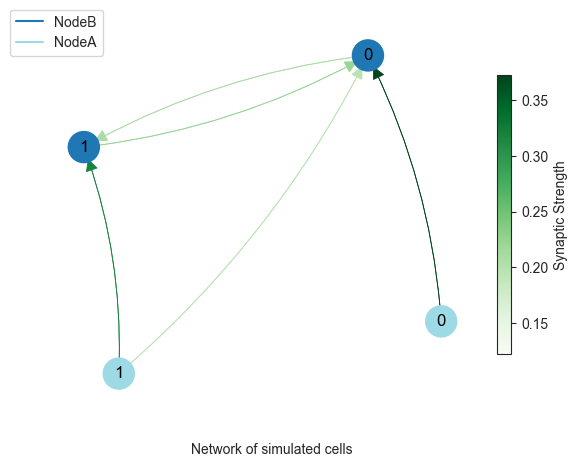

In [20]:
G = build_graph(sim.cells)
plt = plot_graph(G, node_size=500, edge_width=0.6, node_distance=1.8)
plt.savefig("ex2_sonatagraph.pdf")
plt.show()


Finally, we can plot the voltage traces for each cell in the simulation.

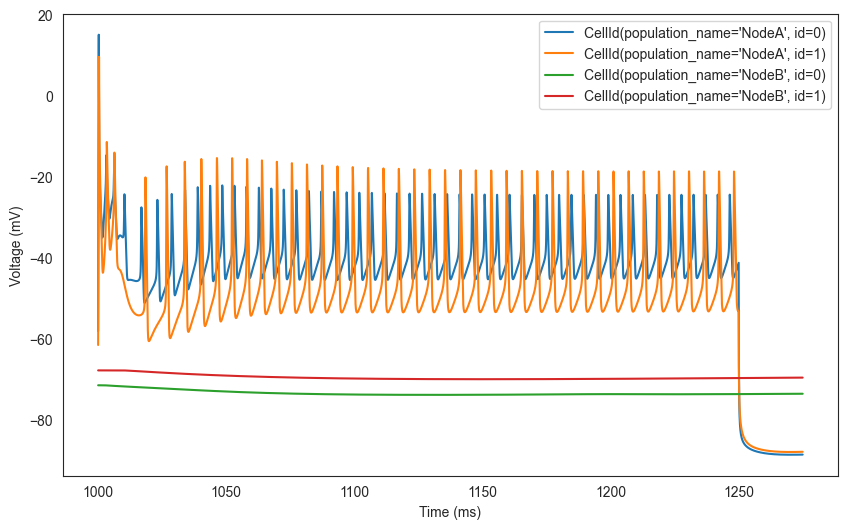

In [21]:
idx_start = int((t_start) / dt) + 1
idx_stop = int(t_stop / dt) + 1
plt.figure(figsize=(10, 6))
for cell_id in sim.cells:
    # Get the voltage trace
    time = sim.get_time_trace(t_start=t_start, t_stop=t_stop)
    voltage = sim.get_voltage_trace(cell_id, t_start=t_start, t_stop=t_stop)
    plt.plot(time, voltage, label=str(cell_id))
    plt.legend()
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")

The figure shows that from all dSTUT cells, only the cells of NodeA population are affected by the Hyperpolarizing input.

## SONATA reports

### Writing Reports in Single or Parallel Simulations

`ReportManager` can write all reports using either:

- `sim.cells` (for single-process simulations), or
- Precomputed traces and spike data (required in parallel runs where results must be gathered from each rank).

In parallel workflows, collect spikes and traces from all ranks before calling `write_all()` to ensure complete reports.

In [22]:
from bluecellulab.reports.manager import ReportManager

report_mgr = ReportManager(sim.circuit_access.config, sim.dt)
report_mgr.write_all(sim.cells)